In [1]:
from break_loop import BreakLoopException
from pathlib import Path
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import ParameterSampler
from timeit import default_timer
import constants as const
import csv
import cv2
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import progressbar as pb
import seaborn as sns
import utils
import utils_flow as ut_fl

In [2]:
# Set the seed value for experiment reproducibility.
SEED = 42
np.random.seed(SEED)
rng = np.random.default_rng(SEED)

In [3]:
log_file = Path(const.logs_path, 'FLOWER.log')
logging.basicConfig(
    format='%(asctime)s %(message)s',
    filemode='a',
    filename=log_file,
    encoding='utf-8',
    level=logging.INFO,
    force=True
)

In [4]:
df = pd.read_csv(Path(const.csv_path, 'dataset.csv'))

In [5]:
OUTPUT_SIZE = [64, 64]
N_FRAMES = 10

# MAX dimensions of bounding box
MAX_WIDTH = MAX_HEIGHT = const.MAX_WIDTH

# Dimensions of generated images
IMG_WIDTH = IMG_HEIGHT = const.IMG_WIDTH

VIDEO_FORMAT_CODECS = const.VIDEO_FORMAT_CODECS

In [28]:
def flow_calc(mode, row, save_path, parameters):

    functions_arr = [
        ut_fl.calc_flow_farneback, ut_fl.calc_flow_TVL1, ut_fl.calc_flow_pyflow
    ]

    flow_function = functions_arr[mode]
    logging.info(row)
    logging.info(parameters)

    timer_start = default_timer()

    low_idx = np.rint(30 * (2 / 3))  # where 30=FPS


    # Extract video name
    path = row.path
    filename = row.filename

    # Get target class of video

    target_name = utils.get_class_string(filename)

    full_path = Path(path, filename)
    video_name = utils.remove_extension(filename)

    # save_path = const.test_flows_path if (test) else const.flows_path

    folder_path = Path(save_path)
    # creates the target folder if needed (parents = True)
    folder_path.mkdir(parents=True, exist_ok=True)

    logging.info(f'Video {index} : {filename}')

    # Find CSV file based on video name

    csv_regex = f'{video_name}.csv'
    path_gen = Path(const.updated_landmarks_path).glob(csv_regex)

    ret_list = list(path_gen)

    try:
        video_csv = ret_list.pop(0)
    except IndexError:
        print(f'ERROR: video {full_path}: no csv file found ({csv_regex})')
        return

    data = pd.read_csv(video_csv)

    fourcc_mp4 = cv2.VideoWriter_fourcc(*VIDEO_FORMAT_CODECS['mp4'])
    out_path = str(Path(save_path, 'video.mp4'))
    out_mp4 = cv2.VideoWriter(
        out_path, fourcc_mp4, 30, (MAX_WIDTH, MAX_HEIGHT), True
    )

    vidcap = cv2.VideoCapture(str(full_path))  # open video

    frames = utils.get_video_frames(vidcap)
    logging.info(f'Class {target_name}, frames: {frames}')

    p2.set_elements(frames)

    fps = utils.get_video_fps(vidcap)

    high_idx = frames - low_idx

    trim_frame = high_idx - low_idx

    seconds = frames / fps

    logging.info(f'Duration: {seconds:.2f}')
    logging.info(f'Speaking Frames: {trim_frame} ({low_idx} - {high_idx}) = \
    {(trim_frame/frames):.2%} of {frames}')

    logging.info('\n')

    is_good_flow = ''
    show = True
    skip = False

    ret, frame1 = vidcap.read()

    ra = utils.calc_bounding_box(data, 1)

    x, y, width, height = ra['box']

    face = frame1[y:y + height, x:x + width, :]

    face = cv2.resize(face, dsize=(MAX_WIDTH, MAX_HEIGHT))

    prvs_rgb = face
    prvs = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)

    hsv = np.zeros_like(face)
    hsv[..., 1] = 255

    vidcap.set(cv2.CAP_PROP_POS_FRAMES, 1)
#    frame_number = 1

    for frame_number in range(1, frames):

        success, image = vidcap.read()

#        frame_idx = frame_number - (low_idx - 1)
        speaking_frame = frame_number >= low_idx and frame_number <= high_idx

        flow_string = f'{video_name}-{frame_number:03d}'
        speaking_string = '01' if speaking_frame else '00'

        save_string = f'{flow_string}-{speaking_string}.jpg'
        ra = utils.calc_bounding_box(data, frame_number)

        x, y, width, height = ra['box']

        face = image[y:y + height, x:x + width, :]

        face = cv2.resize(face, dsize=(MAX_WIDTH, MAX_HEIGHT))

        next_rgb = face
        next = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)

        gr1 = flow_function(
            prvs,
            next,
            parameters,
            logger=logging
        )

        gr1_grey = cv2.cvtColor(gr1, cv2.COLOR_BGR2GRAY)
        prvs = next
        if show is True:
            cv2.imshow('Flow', gr1_grey / 255)
            key = cv2.waitKey(int(1000/fps))
            match key:
                case 27:  # ESC
                    logging.info('Break')
                    logging.info('Bad Flow')
                    is_good_flow = str(0)
                    skip = True
                    break
                case 98:  # letter 'b'
                    logging.info('Bad Flow')
                    is_good_flow = str(0)
                case 104:  # letter 'h' - hide screen
                    logging.info('Hide Screen')
                    show = False
                    cv2.destroyAllWindows()
                case 111:  # letter 'o'
                    logging.info('Good Flow')
                    is_good_flow = str(1)
                case 113:  # q
                    logging.info('EXIT')
                    vidcap.release()
                    out_mp4.release()
                    out_mp4 = None
                    cv2.destroyAllWindows()
                    raise BreakLoopException(
                        f'BLE at video {video_name}: frame {frame_number}'
                    )

        out_mp4.write(gr1)
        gr1_res = cv2.resize(gr1, dsize=(IMG_HEIGHT, IMG_WIDTH))
        cv2.imwrite(str(Path(folder_path, save_string)), gr1_res)

        p2.update_progress(frame_number)

    vidcap.release()
    out_mp4.release()
    out_mp4 = None


    if is_good_flow == '':
        key = cv2.waitKey(7000)  # Wait 7 s for an input
        match key:
            case 98:  # letter 'b'
                logging.info('Bad Flow')
                is_good_flow = str(0)
            case 111:  # letter 'o'
                logging.info('Good Flow')
                is_good_flow = str(1)
            case _:
                logging.info('Not Defined')
                is_good_flow = '-'

    cv2.destroyAllWindows()

    timer_end = default_timer() - timer_start

    csv_path = Path(save_path.parent.parent, 'runs.csv')
    with open(csv_path, 'a+', newline='') as res_file:
        filewriter = csv.writer(res_file, delimiter=',',
                                quoting=csv.QUOTE_MINIMAL)

        values_list = [value for value in params.values()]
        values_list.insert(0, save_path.parent.name)
        values_list.insert(1, video_name)
        values_list.append(timer_end)
        values_list.append('skip' if skip else '')
        values_list.append(is_good_flow)
        filewriter.writerow(
            values_list
        )

    p2.update_progress(frames)

In [48]:
# FARNEBACK
p_0 = {
    'WINSIZE': [3, 7, 10, 15],
    'PYR_SCALE': [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9],
    'POLY_SIGMA': [1.5, 1.7],
    'POLY_N': [5, 7],
    'LEVELS': [3, 5],
    'ITERATIONS': [1, 3, 5, 10],
    'FLAGS': [0]
}

# PYFLOW
p_2 = {
    'pyflow_alpha': [0.1],
    'pyflow_ratio': [0.8],
    'pyflow_minWidth': [3],
    'pyflow_nOuterFPIterations': [1],
    'pyflow_nInnerFPIterations': [1],
    'pyflow_nSORIterations': [1],
    'pyflow_colType': [1]
}
# TVL1
p_1 = {
    'warps': [5],
    'useInitialFlow': [False],
    'theta': [0.3],
    'tau': [0.25],
    'scaleStep': [0.8],
    'outerIterations': [5],
    'nscales': [5],
    'medianFiltering': [5],
    'lambda_': [0.15],
    'innerIterations': [5],
    'gamma': [0.0],
    'epsilon': [0.01]
}

In [49]:
param_grid_ar = [p_0, p_1, p_2]

In [50]:
# GridSearch
# 0: Farneback, 1: TVL1, 2: pyflow
flow_type = 0
param_grid = param_grid_ar[flow_type]
par_space = np.prod([len(x) for x in param_grid.values()])

runs_file = Path('FlowGridSearch/runs.csv')

if not runs_file.is_file():
    with open(runs_file, 'w', newline='') as res_file:
        filewriter = csv.writer(res_file, delimiter=',',
                                quoting=csv.QUOTE_MINIMAL)
        keys_list = [value for value in param_grid.keys()]
        keys_list.insert(0, 'Folder')
        keys_list.insert(1, 'Name')
        keys_list.append('Time')
        keys_list.append('Note')
        keys_list.append('Good')
        filewriter.writerow(keys_list)

iterations = 30
iterations = min(iterations, par_space)


sampler = ParameterSampler(param_grid, iterations, random_state=SEED)

elem_to_take = 1

# Create a random copy of the database and take the first x elements
df_random = df.copy().sample(frac=1, random_state=SEED).reset_index(drop=True)

run = 0

p0 = pb.Progressbar(id='p0', elements=elem_to_take)
p1 = pb.Progressbar(id='p1', elements=iterations)
p2 = pb.Progressbar(id='p2', elements=100)

try:
    for params in sampler:
        run += 1
        print(params)
        p1.add_to_progress(1)
        for index, row in df_random.iloc[:elem_to_take].iterrows():
            p0.add_to_progress(1)
            filename = utils.remove_extension(row.filename)
            out_path = Path('FlowGridSearch', f'Run_{run}', filename)
            flow_calc(flow_type, row, out_path, params)
except BreakLoopException as BLE:
    details = BLE.args[0]
    print(details)

'Progress: [####################] 100%             1/1'

'Progress: [#-------------------] 5%             1/30'

'Progress: [###########---------] 55%             69/123'

{'WINSIZE': 7, 'PYR_SCALE': 0.5, 'POLY_SIGMA': 1.7, 'POLY_N': 5, 'LEVELS': 3, 'ITERATIONS': 1, 'FLAGS': 0}
BLE at video 01-01-07-02-01-01-03: frame 70


In [187]:
# Show all videos in FlowGridSearch folder
gen_all = Path('FlowGridSearch/').rglob('*.mp4')
videos_to_show = 5
p1 = pb.Progressbar('p1', videos_to_show)
gen_slice = (x for _, x in zip(range(videos_to_show), gen_all))

for video in gen_slice:
    p1.add_to_progress(1)
    utils.show_video(video)

'Progress: [####################] 100%             5/5'

No frames grabbed!
No frames grabbed!
No frames grabbed!
No frames grabbed!
No frames grabbed!


In [190]:
# Print Best Results

flow_results_ds = pd.read_csv(Path('FlowGridSearch', 'runs_1-30.csv'),
                              index_col=False)
flow_results_ds

,Folder,Name,WINSIZE,PYR_SCALE,POLY_SIGMA,POLY_N,LEVELS,ITERATIONS,FLAGS,Time,Good
0,Run_1,01-01-07-02-01-01-03,10,0.9,1.7,30,10,1,0,100.168683,0
1,Run_1,01-01-02-01-01-02-11,10,0.9,1.7,30,10,1,0,81.000666,0
2,Run_1,01-01-02-02-01-01-10,10,0.9,1.7,30,10,1,0,91.012019,0
3,Run_2,01-01-07-02-01-01-03,14,0.8,1.7,15,5,5,0,15.604797,0
4,Run_2,01-01-02-01-01-02-11,14,0.8,1.7,15,5,5,0,12.172965,0
...,...,...,...,...,...,...,...,...,...,...,...
85,Run_29,01-01-02-01-01-02-11,14,0.9,1.1,5,20,3,0,13.460320,0
86,Run_29,01-01-02-02-01-01-10,14,0.9,1.1,5,20,3,0,15.110116,0
87,Run_30,01-01-07-02-01-01-03,15,0.6,1.7,30,20,3,0,35.967002,0
88,Run_30,01-01-02-01-01-02-11,15,0.6,1.7,30,20,3,0,29.041801,0


In [191]:
# For every attribute find how many good flow has

n_rows = len(flow_results_ds)
n_good = flow_results_ds['Good'].sum()  # Total goods

print(f'Good: {n_good}/{n_rows} {n_good / n_rows:.2%}')

for col in flow_results_ds.columns[2:-2]:
    print()
    for i in np.sort(flow_results_ds[col].unique()):
        df_i = flow_results_ds.loc[flow_results_ds[col] == i, :]
        col_sum = df_i['Good'].sum()
        ratio = col_sum / n_good
        print(f'{col}:{i} -> {col_sum}/{n_good} Percentage: {ratio:.2%}')

Good: 15/90 16.67%

WINSIZE:7 -> 3/15 Percentage: 20.00%
WINSIZE:8 -> 3/15 Percentage: 20.00%
WINSIZE:10 -> 6/15 Percentage: 40.00%
WINSIZE:12 -> 3/15 Percentage: 20.00%
WINSIZE:14 -> 0/15 Percentage: 0.00%
WINSIZE:15 -> 0/15 Percentage: 0.00%

PYR_SCALE:0.1 -> 9/15 Percentage: 60.00%
PYR_SCALE:0.3 -> 0/15 Percentage: 0.00%
PYR_SCALE:0.6 -> 0/15 Percentage: 0.00%
PYR_SCALE:0.7 -> 3/15 Percentage: 20.00%
PYR_SCALE:0.8 -> 3/15 Percentage: 20.00%
PYR_SCALE:0.9 -> 0/15 Percentage: 0.00%

POLY_SIGMA:1.1 -> 9/15 Percentage: 60.00%
POLY_SIGMA:1.5 -> 0/15 Percentage: 0.00%
POLY_SIGMA:1.7 -> 6/15 Percentage: 40.00%

POLY_N:1 -> 0/15 Percentage: 0.00%
POLY_N:5 -> 3/15 Percentage: 20.00%
POLY_N:15 -> 6/15 Percentage: 40.00%
POLY_N:30 -> 6/15 Percentage: 40.00%

LEVELS:5 -> 0/15 Percentage: 0.00%
LEVELS:10 -> 3/15 Percentage: 20.00%
LEVELS:20 -> 9/15 Percentage: 60.00%
LEVELS:30 -> 3/15 Percentage: 20.00%

ITERATIONS:1 -> 6/15 Percentage: 40.00%
ITERATIONS:3 -> 6/15 Percentage: 40.00%
ITERATIONS:5

### Feature Selection 
1. Univariate Selection
2. Feature Importance
3. Correlation Matrix with Heatmap


In [192]:
X = flow_results_ds.iloc[:, 2:-2]  # independent columns
y = flow_results_ds.iloc[:, -1]  # target column

### Univariate Selection

In [193]:
# Apply SelectKBest class to extract top 5 features
bestfeatures = SelectKBest(score_func=chi2, k=5)
fit = bestfeatures.fit(X, y)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

# Concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']
print(featureScores.nlargest(5, 'Score'))

        Specs      Score
3      POLY_N  29.205634
4      LEVELS   8.417476
0     WINSIZE   3.870732
1   PYR_SCALE   1.285714
2  POLY_SIGMA   0.159083


### Feature Importance

[0.16068507 0.23797977 0.14746138 0.14986977 0.18013473 0.12386927
 0.        ]


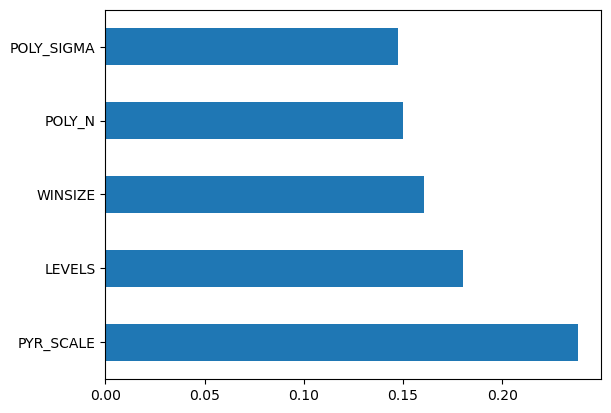

In [194]:
model = ExtraTreesClassifier()
model.fit(X, y)
print(model.feature_importances_)  # use builtin class feature_importances

feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.show()

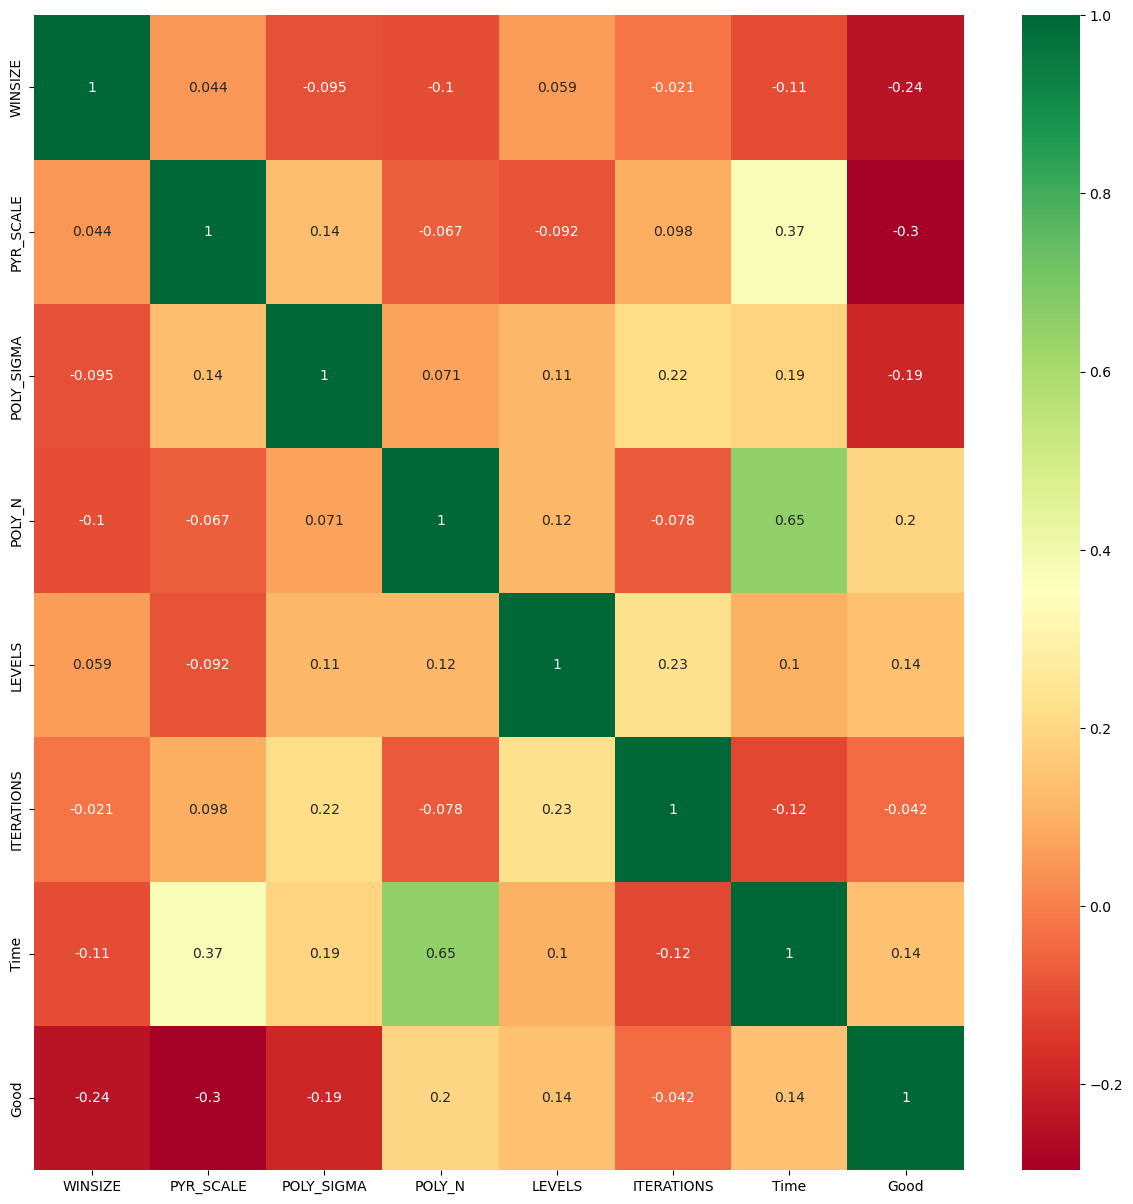

In [195]:
corrmat = flow_results_ds.drop('FLAGS', axis=1).iloc[:, 2:].corr()
top_corr_features = corrmat.index
plt.figure(figsize=(15, 15))

g = sns.heatmap(flow_results_ds[top_corr_features].corr(),
                annot=True, cmap="RdYlGn")

## Flow Generation